✅ 计算完成！已保存 298 个患者的 EEG 记录时长（单位：秒）
✅ 共有 298 名患者数据匹配
⚠️ 292 名患者的时长误差超过 3600 秒（1 小时）
         pat_ID  duration_seconds_ssd  duration_seconds_eeg  time_diff
0    ICARE_0004                 92275                  8700      83575
1    ICARE_0009                     0                 51000      51000
2    ICARE_0013                518515                139200     379315
4    ICARE_0025                317639                 21000     296639
5    ICARE_0026                166875                 19800     147075
..          ...                   ...                   ...        ...
293  ICARE_1007                215774                195600      20174
294  ICARE_1008                252315                 99000     153315
295  ICARE_1009                111694                 14100      97594
296  ICARE_1012                701180                270900     430280
297  ICARE_1018                789549                 20700     768849

[292 rows x 4 columns]

🔍 时间误差统计（单位：秒）
- 平均误差: 185988.96 秒
- 中位误

/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 24739 (\N{CJK UNIFIED IDEOGRAPH-60A3}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 32773 (\N{CJK UNIFIED IDEOGRAPH-8005}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 37327 (\N{CJK UNIFIED IDEOGRAPH-91CF}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/yinziyuan/opt/anaconda3/lib/python3.9/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 35760 (\N{CJK UNIF

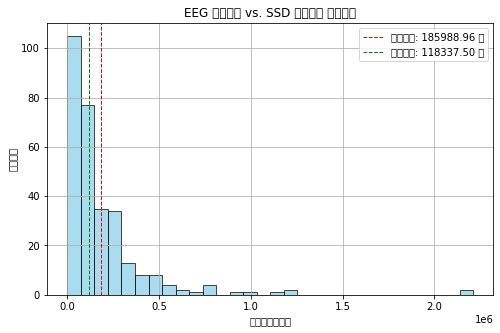


🔍 误差最大的 5 名患者（单位：秒）：
         pat_ID  duration_seconds_ssd  duration_seconds_eeg  time_diff
74   ICARE_0266               2486971                274800    2212171
38   ICARE_0130               2211656                 42600    2169056
291  ICARE_0995               1263443                 11100    1252343
15   ICARE_0063               1474456                242400    1232056
135  ICARE_0472               1209592                101700    1107892


In [26]:
import os
import pandas as pd
import matplotlib.pyplot as plt

# === 1. 计算 EEG 记录时长（单位：秒） ===
data_folder = "5min_smoothed_data/"  # EEG 数据文件夹
valid_outcome_data = "valid_patients_outcome.csv"  # 有效患者标签文件

# 读取有效患者 ID
outcome_df = pd.read_csv(valid_outcome_data)
valid_patients = set(outcome_df["pat_ID"])  # 只处理 valid_patients_outcome.csv 里的 pat_ID

# 计算每个 pat_ID 的 EEG 时长（单位：秒）
patient_durations = {}

for filename in sorted(os.listdir(data_folder)):
    if filename.endswith(".csv"):
        patient_id = filename.split(".")[0]  # 提取 pat_ID

        if patient_id in valid_patients:  # 只处理 valid 的患者
            file_path = os.path.join(data_folder, filename)
            try:
                data = pd.read_csv(file_path)

                # 计算该患者的 EEG 记录时长（每行代表 5 分钟 = 300 秒）
                duration_seconds = len(data) * 300

                patient_durations[patient_id] = duration_seconds
            except Exception as e:
                print(f"❌ 读取 {file_path} 失败: {e}")

# 转换为 DataFrame 并保存（单位：秒）
eeg_df = pd.DataFrame(list(patient_durations.items()), columns=["pat_ID", "duration_seconds"])
eeg_df.sort_values("duration_seconds", ascending=False, inplace=True)  # 按时长排序
eeg_df.to_csv("patient_durations.csv", index=False)

print(f"✅ 计算完成！已保存 {len(eeg_df)} 个患者的 EEG 记录时长（单位：秒）")

# === 2. 计算 SSD 记录的时长（单位：秒） ===
ssd_df = pd.read_csv("files_art_ssd_fts_predictions.csv", sep=None, engine="python", encoding="utf-8-sig")

# 修正列名，去除前后空格
ssd_df.columns = ssd_df.columns.str.strip()

# 提取 pat_ID（去掉时间部分）
ssd_df["pat_ID"] = ssd_df["fn"].str.extract(r"(ICARE_\d+)")  

# 计算每个 pat_ID 的最小和最大 rosc_sec
ssd_duration = ssd_df.groupby("pat_ID")["rosc_sec"].agg(["min", "max"])
ssd_duration["duration_seconds"] = ssd_duration["max"] - ssd_duration["min"]
ssd_duration.reset_index(inplace=True)

# === 3. 匹配 SSD 和 EEG 数据 ===
merged_df = ssd_duration[["pat_ID", "duration_seconds"]].merge(
    eeg_df[["pat_ID", "duration_seconds"]], on="pat_ID", suffixes=("_ssd", "_eeg")
)

# 计算时间误差（秒）
merged_df["time_diff"] = (merged_df["duration_seconds_ssd"] - merged_df["duration_seconds_eeg"]).abs()

# 设定误差阈值（1 小时 = 3600 秒）
error_threshold = 3600
time_mismatch = merged_df[merged_df["time_diff"] > error_threshold]

# === 4. 输出结果 ===
print(f"✅ 共有 {len(merged_df)} 名患者数据匹配")
print(f"⚠️ {len(time_mismatch)} 名患者的时长误差超过 3600 秒（1 小时）")
print(time_mismatch)

# === 5. 统计误差情况 ===
mean_diff = merged_df["time_diff"].mean()
median_diff = merged_df["time_diff"].median()
max_diff = merged_df["time_diff"].max()
min_diff = merged_df["time_diff"].min()

print("\n🔍 时间误差统计（单位：秒）")
print(f"- 平均误差: {mean_diff:.2f} 秒")
print(f"- 中位误差: {median_diff:.2f} 秒")
print(f"- 最大误差: {max_diff:.2f} 秒")
print(f"- 最小误差: {min_diff:.2f} 秒")

# === 6. 绘制时间误差分布 ===
plt.figure(figsize=(8, 5))
plt.hist(merged_df["time_diff"], bins=30, color="skyblue", edgecolor="black", alpha=0.7)
plt.axvline(mean_diff, color="red", linestyle="dashed", linewidth=1, label=f"平均误差: {mean_diff:.2f} 秒")
plt.axvline(median_diff, color="green", linestyle="dashed", linewidth=1, label=f"中位误差: {median_diff:.2f} 秒")
plt.xlabel("时间误差（秒）")
plt.ylabel("患者数量")
plt.title("EEG 记录时长 vs. SSD 记录时长 误差分布")
plt.legend()
plt.grid()
plt.show()

# === 7. 找出误差最大的 5 名患者 ===
top_mismatch = merged_df.nlargest(5, "time_diff")
print("\n🔍 误差最大的 5 名患者（单位：秒）：")
print(top_mismatch)

# === 8. 保存结果 ===
merged_df.to_csv("matched_patient_durations.csv", index=False)
time_mismatch.to_csv("time_mismatch_patients.csv", index=False)
top_mismatch.to_csv("top_5_time_mismatch.csv", index=False)

In [27]:
# === 1. 计算 EEG > SSD 的情况 ===
eeg_longer = merged_df[merged_df["duration_seconds_eeg"] > merged_df["duration_seconds_ssd"]]
ssd_longer = merged_df[merged_df["duration_seconds_ssd"] > merged_df["duration_seconds_eeg"]]

# === 2. 统计结果 ===
print(f"✅ EEG 计算的时长 > SSD 计算的时长的患者数量: {len(eeg_longer)}")
print(f"⚠️ SSD 计算的时长 > EEG 计算的时长的患者数量: {len(ssd_longer)}")

# === 3. 输出 EEG > SSD 的 TOP 5 患者 ===
top_eeg_longer = eeg_longer.nlargest(5, "time_diff")
print("\n🔍 EEG 计算的时长远大于 SSD 计算的时长的 TOP 5 患者（单位：秒）：")
print(top_eeg_longer)

✅ EEG 计算的时长 > SSD 计算的时长的患者数量: 65
⚠️ SSD 计算的时长 > EEG 计算的时长的患者数量: 233

🔍 EEG 计算的时长远大于 SSD 计算的时长的 TOP 5 患者（单位：秒）：
         pat_ID  duration_seconds_ssd  duration_seconds_eeg  time_diff
49   ICARE_0175                     0                263100     263100
165  ICARE_0558                     0                262200     262200
71   ICARE_0257                     0                230100     230100
224  ICARE_0771                     0                182400     182400
155  ICARE_0535                     0                164700     164700


In [4]:
import pandas as pd

# **尝试使用逗号 `,` 作为分隔符**
df = pd.read_csv("finalAbstractDataset.csv", delimiter=",", encoding="utf-8-sig")

# **再次打印列名检查**
print("修正后的 CSV 列名:", df.columns.tolist())

# **去除列名中的空格**
df.columns = df.columns.str.strip()

# **检查 'pat_ID' 和 'hour' 是否存在**
expected_cols = {"pat_ID", "hour"}
missing_cols = expected_cols - set(df.columns)

if missing_cols:
    raise KeyError(f"缺少列: {missing_cols}，请检查 CSV 文件的列名是否正确！")

# **确保 hour 列是数值类型**
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")

# **计算每个 pat_ID 的最小和最大 hour**
duration = df.groupby("pat_ID")["hour"].agg(["min", "max"])

# **计算持续时间**
duration["duration"] = duration["max"] - duration["min"]

# **打印最终结果**
print(duration)

修正后的 CSV 列名: ['pat_ID', 'cohort', 'hour', 'GPD_vec_ct_div_360', 'num_10s_vec_in_hour', 'BCI', 'BSAR', 'SIQ', 'SIQ_alpha', 'SIQ_beta', 'SIQ_delta', 'SIQ_theta', 'SignalSD', 'alphakurtosis', 'alphameanrat', 'alphaminrat', 'alphapctrat', 'alphastdrat', 'avgspectent', 'avgspectkurt', 'betakurtosis', 'betameanrat', 'betaminrat', 'betapctrat', 'betastdrat', 'corrmean', 'd0MaxAmp', 'd0MaxMaxFourAmp', 'd0MeanMaxAmp', 'd0MeanMaxFourAmp', 'd0MeanVarAmp', 'd0VarMaxAmp', 'd0VarMaxFourAmp', 'd0VarMeanAmp', 'd0VarVarAmp', 'd1MaxAmp', 'd1MaxMaxFourAmp', 'd1MeanMaxAmp', 'd1MeanMaxFourAmp', 'd1MeanVarAmp', 'd1VarMaxAmp', 'd1VarMaxFourAmp', 'd1VarMeanAmp', 'd1VarVarAmp', 'd2MaxAmp', 'd2MaxMaxFourAmp', 'd2MeanMaxAmp', 'd2MeanMaxFourAmp', 'd2MeanVarAmp', 'd2VarMaxAmp', 'd2VarMaxFourAmp', 'd2VarMeanAmp', 'd2VarVarAmp', 'deltaalphamean', 'deltaalphamin', 'deltaalphapct', 'deltaalphastd', 'deltakurtosis', 'deltameanrat', 'deltaminrat', 'deltapctrat', 'deltastdrat', 'deltathetamean', 'deltathetamin', 'deltath

In [9]:
# 过滤 min 或 max 超出 16~68 小时范围的患者
out_of_range = duration[(duration["min"] < 16) ]

# 打印不符合条件的患者
print("不在 16 到 68 小时范围内的患者:")
print(out_of_range)

# 统计数量
print(f"\n共有 {len(out_of_range)} 名患者的 min 或 max 超出范围。")

不在 16 到 68 小时范围内的患者:
            min  max  duration
pat_ID                        
ICARE_0079    9   45        36
ICARE_0109   14   43        29
ICARE_0124   14   68        54
ICARE_0146   11   41        30
ICARE_0195    9   68        59
ICARE_0259   13   84        71
ICARE_0285   12   31        19
ICARE_0302   11   26        15
ICARE_0304    9   85        76
ICARE_0328   13   64        51
ICARE_0330   14   70        56
ICARE_0348    6  120       114
ICARE_0372    8   21        13
ICARE_0385   13   61        48
ICARE_0396   15   56        41
ICARE_0420   11   50        39
ICARE_0428   13   60        47
ICARE_0470   12   23        11
ICARE_0520   15   82        67
ICARE_0540    5   24        19
ICARE_0553   10  120       110
ICARE_0558   14   89        75
ICARE_0602   12   54        42
ICARE_0643    9  105        96
ICARE_0654    6   57        51
ICARE_0698   12   99        87
ICARE_0700   14  105        91
ICARE_0710    4  117       113
ICARE_0723   11   15         4
ICARE_0726   14   

In [11]:
import os
import pandas as pd

# === 1. 参数设置 ===
data_folder = "5min_smoothed_data/"  # EEG 数据文件夹
valid_outcome_data = "valid_patients_outcome.csv"  # 有效患者的标签文件

# === 2. 读取有效患者 ID ===
outcome_df = pd.read_csv(valid_outcome_data)
valid_patients = set(outcome_df["pat_ID"])  # 只处理 valid_patients_outcome.csv 里存在的 pat_ID

# === 3. 计算真实时长 ===
patient_durations = {}

# 遍历 5min_smoothed_data 文件夹中的 CSV 文件
file_list = sorted([f for f in os.listdir(data_folder) if f.endswith(".csv")])

for filename in file_list:
    patient_id = filename.split(".")[0]  # 提取 pat_ID
    
    if patient_id in valid_patients:  # 只处理 valid_patients_outcome.csv 里有的患者
        file_path = os.path.join(data_folder, filename)
        data = pd.read_csv(file_path)

        # 计算该患者的 EEG 记录时长（每行代表 5 分钟）
        duration_minutes = len(data) * 5  # 行数 × 5 分钟

        patient_durations[patient_id] = duration_minutes

# === 4. 转换为 DataFrame 并保存 ===
duration_df = pd.DataFrame(list(patient_durations.items()), columns=["pat_ID", "duration_minutes"])
duration_df.sort_values("duration_minutes", ascending=False, inplace=True)  # 按时长排序
print(duration_df)

# 保存结果到 CSV
duration_df.to_csv("patient_durations.csv", index=False)

         pat_ID  duration_minutes
103  ICARE_0348              5695
201  ICARE_0710              5080
168  ICARE_0566              4940
7    ICARE_0035              4700
112  ICARE_0375              4645
..          ...               ...
170  ICARE_0579                40
196  ICARE_0687                40
161  ICARE_0550                20
13   ICARE_0055                10
232  ICARE_0793                 5

[298 rows x 2 columns]


In [15]:
import pandas as pd

# === 1. Read patient_durations.csv ===
duration_df = pd.read_csv("patient_durations.csv")
duration_patients = set(duration_df["pat_ID"])

# === 2. Read finalAbstractDataset.csv ===
df = pd.read_csv("finalAbstractDataset.csv", delimiter=",", encoding="utf-8-sig")
df.columns = df.columns.str.strip()  # Remove whitespace from column names
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")  # Ensure 'hour' is numeric
final_patients = set(df["pat_ID"])

# === 3. Compare pat_ID differences ===
only_in_durations = duration_patients - final_patients  # Exists only in patient_durations.csv
only_in_final = final_patients - duration_patients  # Exists only in finalAbstractDataset.csv

# === 4. Output unmatched pat_IDs ===
print(f"Patients found only in patient_durations.csv but not in finalAbstractDataset.csv: {len(only_in_durations)}")
print(only_in_durations)

print(f"\nPatients found only in finalAbstractDataset.csv but not in patient_durations.csv: {len(only_in_final)}")
print(only_in_final)

Patients found only in patient_durations.csv but not in finalAbstractDataset.csv: 0
set()

Patients found only in finalAbstractDataset.csv but not in patient_durations.csv: 2
{'ICARE_0792', 'ICARE_0730'}


In [16]:
import pandas as pd

# === 1. Read patient_durations.csv (minutes) ===
duration_df = pd.read_csv("patient_durations.csv")
duration_df["duration_hours"] = duration_df["duration_minutes"] / 60  # Convert to hours
duration_patients = set(duration_df["pat_ID"])

# === 2. Read finalAbstractDataset.csv (hours) ===
df = pd.read_csv("finalAbstractDataset.csv", delimiter=",", encoding="utf-8-sig")
df.columns = df.columns.str.strip()  # Clean column names
df["hour"] = pd.to_numeric(df["hour"], errors="coerce")  # Ensure 'hour' is numeric
final_duration = df.groupby("pat_ID")["hour"].agg(["min", "max"])
final_duration["duration_hours"] = final_duration["max"] - final_duration["min"]
final_patients = set(final_duration.index)

# === 3. Find pat_IDs present in both datasets ===
common_patients = duration_patients & final_patients

# === 4. Merge both datasets for time comparison ===
merged_df = duration_df[["pat_ID", "duration_hours"]].merge(
    final_duration[["duration_hours"]], left_on="pat_ID", right_index=True, suffixes=("_minutes", "_hours")
)

# === 5. Calculate error threshold (default ±1 hour) ===
error_threshold = 1.0
merged_df["time_diff"] = (merged_df["duration_hours_minutes"] - merged_df["duration_hours_hours"]).abs()

# === 6. Filter out patients whose time difference exceeds the threshold ===
time_mismatch = merged_df[merged_df["time_diff"] > error_threshold]

# === 7. Output results ===
print(f"There are {len(common_patients)} patients present in both datasets.")
print(f"{len(time_mismatch)} patients have a time difference exceeding {error_threshold} hours:\n")
print(time_mismatch)

There are 298 patients present in both datasets.
246 patients have a time difference exceeding 1.0 hours:

         pat_ID  duration_hours_minutes  duration_hours_hours  time_diff
0    ICARE_0348               94.916667                   114  19.083333
1    ICARE_0710               84.666667                   113  28.333333
2    ICARE_0566               82.333333                    91   8.666667
3    ICARE_0035               78.333333                    87   8.666667
4    ICARE_0375               77.416667                    80   2.583333
..          ...                     ...                   ...        ...
285  ICARE_0068                1.833333                     0   1.833333
287  ICARE_0072                1.666667                    16  14.333333
289  ICARE_0232                1.333333                     0   1.333333
294  ICARE_0687                0.666667                    22  21.333333
296  ICARE_0055                0.166667                    17  16.833333

[246 rows x 4 co